<a href="https://colab.research.google.com/github/sanketsans/Image-Matting-U-Net/blob/master/ImageMatting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from PIL import Image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sanketthakur","key":"a97a4e8e6996eb92ad8d022e38a9aeb8"}'}

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [0]:
!kaggle datasets list -s 'Matting Human'

ref                                             title                                    size  lastUpdated          downloadCount  
----------------------------------------------  --------------------------------------  -----  -------------------  -------------  
laurentmih/aisegmentcom-matting-human-datasets  AISegment.com - Matting Human Datasets   29GB  2019-06-06 18:35:59           2270  
vbookshelf/art-by-ai-neural-style-transfer      Art by Ai - Neural Style Transfer       463MB  2019-06-25 02:05:27             91  
4quant/interactivesegmentation                  InteractiveSegmentation                  17MB  2018-01-10 13:55:35            235  


In [0]:
!kaggle datasets download 'laurentmih/aisegmentcom-matting-human-datasets' -p /content/gdrive/My\ Drive/HumanMattingDatasets/

100% 28.8G/28.8G [09:15<00:00, 86.5MB/s]
100% 28.8G/28.8G [09:15<00:00, 55.6MB/s]


### To unzip the datasets

In [0]:
# import os
# import matplotlib.pyplot as plt
# from PIL import Image
# import cv2
# os.chdir('/content/gdrive/My Drive/HumanMattingDatasets/')
# for file in os.listdir(os.getcwd()):
#   # print(file)
#   os.system('unzip ' + file)

### To check the number of images in each folder

In [3]:
# start_id = '00000000'
# end_id = '00000010'

feat_img_dir = '/content/gdrive/My Drive/HumanMattingDatasets/matting/1803151818/matting_000000'
i = 0
for x in range(11):
  folder_num = str(x).zfill(2)
  folder = feat_img_dir + folder_num + '/'
  j = 0
  for file in os.listdir(folder):
    j += 1
  # print(j)
  i += j

print('total', i)


total 4813


## Creating an Image dataset for feature Image & target Image

In [0]:
class ImageDatasets(Dataset):
  def __init__(self, transform=None, root='/content/gdrive/My Drive/HumanMattingDatasets/', device=None):
    self.root = root
    self.feat_img_path = self.root + 'clip_img/1803151818/'
    self.target_img_path = self.root + 'matting/1803151818/'
    self.transform = transform
    self.device = device 
    self.ft_imgs = self.load_images(self.feat_img_path)
    self.tar_imgs = self.load_images(self.target_img_path)

  def __len__(self):
    if (len(self.ft_imgs) == len(self.tar_imgs)):
      return len(self.ft_imgs)

    else:
      return 0

  def __getitem__(self, index):
    ft = self.ft_imgs[index]
    tar = self.tar_imgs[index]

    feat_img = Image.open(ft)
    target_img = Image.open(tar)

    if self.transform:
      feat_img = self.transform(feat_img)
      target_img = self.transform(target_img)

    return feat_img, target_img

  def load_images(self, path):
    img_path = []
    fid = 0
    for folder in sorted(os.listdir(path)):
      fid = folder.split('_')[1]
      if(int(fid) > 20):
        break
      for file in sorted(os.listdir(path + folder)):
        img_path.append(path + folder + '/' + file)

    return img_path

In [0]:
transform = transforms.Compose([transforms.Resize((256, 256)),
                                transforms.ToTensor()])

In [5]:
dataset = ImageDatasets(transform)
f, t = dataset[5]

print(f.shape, t.shape, len(dataset))

torch.Size([3, 256, 256]) torch.Size([4, 256, 256]) 9215


In [22]:
# x = torch.cat([f, t])
# x.shape

torch.Size([7, 256, 256])

## Splitting the dataset for training, validation and test purposes

In [6]:
split = 0.8
dataset_size = len(dataset)
indices = list(range(dataset_size))
train_indices = indices[ : int(dataset_size*split)]
val_indices = indices[int(dataset_size*split) : dataset_size-int(dataset_size*0.1)]
test_indices = indices[dataset_size-int(dataset_size*0.1) :]

print(len(train_indices), len(val_indices), len(test_indices))

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

7372 922 921


## Creating dataloader

In [0]:
BATCH_SIZE = 16
trainLoader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
valLoader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=valid_sampler)
testLoader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

In [8]:
a = iter(trainLoader)
f, t = next(a)
f.shape

torch.Size([16, 3, 256, 256])

In [50]:
f[0].shape

torch.Size([3, 256, 256])

In [51]:
t[0].shape

torch.Size([4, 256, 256])

## Checking our dataloader to produce correct pair of feature & target Images.


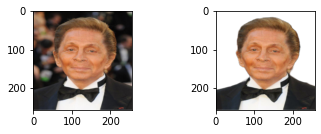

In [9]:
i1 = torchvision.transforms.ToPILImage()(f[10])
i2 = torchvision.transforms.ToPILImage()(t[10])
fig = plt.figure()
a1 = fig.add_subplot(221)
a1.imshow(i1)
a2 = fig.add_subplot(222)
a2.imshow(i2)

plt.show()

In [0]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-255.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [0]:
def conv(in_channel, out_channel, kernel_size=3, stride=1, padding=1, batchNorm=False):
  layers = []
  layers.append(nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding, bias=False))
  if batchNorm:
    layers.append(nn.BatchNorm2d(out_channel))

  return nn.Sequential(*layers)

In [0]:
def deconv(in_channel, out_channel, kernel_size=4, stride=2, padding=1, batchNorm=False):
  layers = []
  layers.append(nn.ConvTranspose2d(in_channel, out_channel, kernel_size, stride, padding, bias=False))
  if batchNorm:
    layers.append(nn.BatchNorm2d(out_channel))

  return nn.Sequential(*layers)

In [0]:
def in_conv(in_channel, out_channel, batchNorm, kernel_size=3, stride=1, padding=1):
  conv1 = conv(in_channel, out_channel, kernel_size, stride, padding, batchNorm)
  conv2 = conv(out_channel, out_channel, kernel_size, stride, padding, batchNorm)

  layers = [conv1, conv2]

  return nn.Sequential(*layers)

In [0]:
def down_samp_conv(in_channel, out_channel, batchNorm, kernel_size=3, stride=1, padding=1):
  pool_layer = nn.MaxPool2d(2, 2)
  conv_layers = in_conv(in_channel, out_channel, batchNorm)

  layers = [pool_layer, conv_layers]
  return nn.Sequential(*layers)

In [0]:
def up_samp_conv(in_channel, out_channel, batchNorm, kernel_size=4, stride=2, padding=1):
  deconv_layer = deconv(in_channel, out_channel, kernel_size, stride, padding, batchNorm)

  return nn.Sequential(deconv_layer)

In [0]:
class Generator(nn.Module):
  def __init__(self, conv_dims=32):
    super(Generator, self).__init__()
    self.seed = 42
    ## input 3x256x256
    self.in_layer = in_conv(3, conv_dims, True) ## 32x256x256

    self.down_samp_conv1 = down_samp_conv(conv_dims, conv_dims*2, True) ## 64x128x128
    self.down_samp_conv2 = down_samp_conv(conv_dims*2, conv_dims*4, True) ## 128x64x64
    self.down_samp_conv3 = down_samp_conv(conv_dims*4, conv_dims*8, True) ## 256x32x32

    self.up_samp_conv1 = up_samp_conv(conv_dims*8, conv_dims*4, True)  ## 128x64x64
    self.up_concat_conv1 = in_conv(conv_dims*8, conv_dims*4, True)
    self.up_samp_conv2 = up_samp_conv(conv_dims*4, conv_dims*2, True) ## 64x128x128
    self.up_concat_conv2 = in_conv(conv_dims*4, conv_dims*2, True)
    self.up_samp_conv3 = up_samp_conv(conv_dims*2, conv_dims, True) ## 32x256x256
    self.up_concat_conv3 = in_conv(conv_dims*2, conv_dims, True)

    self.out_layer = nn.Sequential(*[conv(conv_dims, 4, batchNorm=True),
                                     conv(4, 4)])
    
    # in_conv(conv_dims, 4)

  def forward(self, x):
    ## Input size 3x256x256
    l1 = F.relu(self.in_layer(x)) ## 32x256x256
    d_l2 = F.relu(self.down_samp_conv1(l1)) ## 64x128x128
    d_l3 = F.relu(self.down_samp_conv2(d_l2)) ## 128x64x64
    d_l4 = F.relu(self.down_samp_conv3(d_l3)) ## 256x32x32

    up_l1 = F.relu(self.up_samp_conv1(d_l4)) ## 128x64x64
    up_l1_concat = torch.cat([up_l1, d_l3], dim=1) ## 256x64x64
    up_l1 = F.relu(self.up_concat_conv1(up_l1_concat))  ## 128x64x64

    up_l2 = F.relu(self.up_samp_conv2(up_l1)) ## 64x128x128
    up_l2_concat = torch.cat([up_l2, d_l2], dim=1) ## 128x128x128
    up_l2 = F.relu(self.up_concat_conv2(up_l2_concat))  ## 64x128x128

    up_l3 = F.relu(self.up_samp_conv3(up_l2)) ## 32x256x256
    up_l3_concat = torch.cat([up_l3, l1], dim=1) ## 64x256x256
    up_l3 = F.relu(self.up_concat_conv3(up_l3_concat))  ## 32x256x256

    out_layer = torch.tanh(self.out_layer(up_l3)) ## 4x256x256

    return out_layer


In [0]:
class Discriminator(nn.Module):
  def __init__(self, conv_dims=32):
    super(Discriminator, self).__init__()
    self.seed = 42
    self.conv1 = conv(4, conv_dims)
    self.conv2 = conv(conv_dims, conv_dims*2, batchNorm=True)
    self.conv3 = conv(conv_dims*2, conv_dims*4, batchNorm=True)
    self.conv4 = conv(conv_dims*4, conv_dims*8, batchNorm=True)
    self.conv5 = conv(conv_dims*8, conv_dims*16)

  def forward(self, x):
    x = F.leaky_relu(self.conv1(x), 0.2)
    x = F.leaky_relu(self.conv2(x), 0.2)
    x = F.leaky_relu(self.conv3(x), 0.2)
    x = F.leaky_relu(self.conv4(x), 0.2)
    x = self.conv5(x)

    return x

In [0]:
G, D = Generator(), Discriminator()
G = G.to(device)
D = D.to(device)

In [0]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    # how close is the produced output from being "false"?
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # as absolute value difference between the real and reconstructed images
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    # return weighted loss
    return lambda_weight*reconstr_loss

In [0]:
# hyperparams for Adam optimizers
lr= 0.0002
beta1= 0.5
beta2= 0.99

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])

In [47]:
len(trainLoader)

461

In [0]:
out = G(f)

In [23]:
out.shape

torch.Size([16, 4, 256, 256])

In [0]:
def view_samples(epoch, samples):
  fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
  for ax, fimg in zip(axes.flatten(), samples[epoch]):
    # img = img.detach().cpu().numpy()
    # img = np.transpose(img, (1, 2, 0))
    # img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
    # # print(min(img), max(img))
    # ax.xaxis.set_visible(False)
    # ax.yaxis.set_visible(False)
    # im = ax.imshow(img.reshape((256,256,4)))

    fimg = fimg.detach().cpu().numpy()
    fimg = np.transpose(fimg, (1, 2, 0))
    fimg = ((fimg +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
    # print(min(img), max(img))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(fimg.reshape((256,256,4)))

  plt.show()

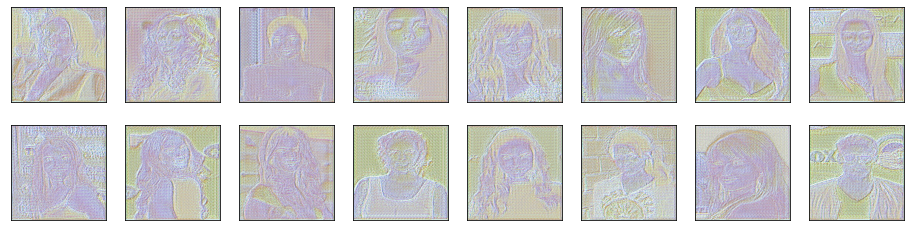

In [75]:
view_samples(0, out)

In [0]:
val_iter = iter(valLoader)
val_fixed_feat, val_fixed_tar = next(val_iter)

In [0]:
def training_loop(trainLoader, valLoader, n_epochs=4000):
  print_every = 10
  losses = []
  samples = []

  val_iter = iter(valLoader)
  val_fixed_feat, val_fixed_tar = next(val_iter)
  val_fixed_feat = val_fixed_feat[0].to(device)
  val_fixed_tar = val_fixed_tar[0].to(device)

  iter_train_img = iter(trainLoader)
  batches_per_epochs = len(trainLoader)
  for epoch in range(n_epochs):
    if epoch % batches_per_epochs == 0:
      iter_train_img = iter(trainLoader)

    feat_img, tar_img = next(iter_train_img)

    feat_img = scale(feat_img)
    tar_img = scale(tar_img)

    feat_img = feat_img.to(device)
    tar_img = tar_img.to(device)

    ## Discriminator
    d_optimizer.zero_grad()
    out_tar = D(tar_img)
    d_loss_tar = real_mse_loss(out_tar)

    fake_img = G(feat_tar)
    out_feat = D(fake_img)
    d_loss_feat = fake_mse_loss(out_feat)

    d_loss = d_loss_tar + d_loss_feat
    d_loss.backward()
    d_optimizer.step()

    ## Generator
    g_optimizer.zero_grad()
    fake_img = G(feat_tar)
    out_feat = D(fake_img)
    g_loss_tar = real_mse_loss(out_feat)
    reconstructed_loss = cycle_consistency_loss(tar_img, fake_img, lambda_weight=10)
    g_loss = g_loss_tar + reconstructed_loss
    g_loss.backward()
    g_optimizer.step()

    G.eval() # for generating samples
    with torch.no_grad():
      samples_z = G(val_fixed_feat)
      samples.append(samples_z)
      view_samples(-1, samples)
    G.train() # back to training mode

    if epoch % print_every == 0:
      losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
      print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
              epoch, n_epochs, d_loss.item(), g_loss.item()))
      

      print('saving data .. ')
      torch.save(G.state_dict(), '/content/gdrive/My Drive/Datasets/img_matting_checkpoint_G.pth')
      torch.save(D.state_dict(), '/content/gdrive/My Drive/Datasets/img_matting_checkpoint_D.pth')

      pkl_file = open('/content/gdrive/My Drive/Datasets/img_matting_train_samples.pkl', 'wb')
      pkl.dump(samples, pkl_file)
      pkl_file.close()





In [28]:
training_loop(trainLoader, valLoader)

RuntimeError: ignored

In [22]:
out = G(f[0])

torch.Size([16, 256, 64, 64])
torch.Size([16, 128, 64, 64])


In [23]:
out.shape

torch.Size([16, 4, 256, 256])

In [122]:
out[0].shape

torch.Size([4, 256, 256])

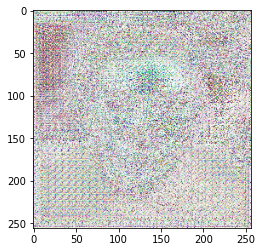

In [24]:
x = torchvision.transforms.ToPILImage()(out[0])
plt.imshow(x)
plt.show()